### <center><b>Audio Emotion Classifier</b></center>
### <center><b>Part 1 - Data Exploration</b></center>
### <center><b>Done By: Sandhya Palaniappan</b></center>

### **Introduction.**
We are going to build an audio emotion classifier. But why, you ask, are we doing this? Well, for a few reasons:

- **Its becoming fairly important**<br/>
At least here in Australia, due to the recent fallout of the Royal Commission, there's more scrutiny than ever into the financial sector. One of the areas that traditionally have been ignored by the government is contact centres, many of which generate contracts through telephone conversations. So compliance is a hot topic right now.

- **Because we can**<br/>
With recent advancements in Deep Learning, better hardware, and more open sourcing of data, this enables us to build capabilities that we couldn't before. So, why not?

- **Accessibility**<br/>
I've specifically chosen emotion as our target because it's one of the more accessible **labeled** datasets. Don't misunderstand; there are many good quality audio datasets out there, but many are either not relevant (e.g., background noises) or locked behind a paywall. Emotions are probably relevant enough since we are dealing with conversations between agents and customers, and there's a variety of sources. Also, emotions are general enough (not context-dependent), so we can apply them to a vast number of different projects.

This is part of IT1364 - Data Analysis & Visualisation. It's going to be a 6 to 7 part series at least. It could be more, but not less. Part 2 covers feature extraction while Parts 3 and 4 dive into the modeling. But to train a model, we need data. So in Part 1 here, we are going to explore a few open-sourced data sources:

- Surrey Audio-Visual Expressed Emotion (SAVEE)
- Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
- Toronto emotional speech set (TESS)
- Crowd-sourced Emotional Multimodal Actors Dataset (CREMA-D)

The ultimate endgame is to achieve the best accuracy that will generalize across unseen data. Right now, it's unclear how we mix and match (or exclude) our datasets, so that's why we need to explore them first. So let's begin. <br><br>

### **Contents.**
1. SAVEE dataset
    * Load the dataset
    * Explore the data
    * Conclusion
2. RAVDESS dataset
    * Load the dataset
    * Explore the data
    * Conclusion
3. TESS dataset
    * Load the dataset
    * Explore the data
    * Conclusion
4. CREMA-D dataset
    * Load the dataset
    * Explore the data
    * Conclusion
5. Final thoughts. <br><br>

In [ ]:
# Import libraries.
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook.
import os
import sys
import warnings
# ignore warnings.
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

The 4 sources of the datasets are all on Kaggle so I've just imported them into the workspace. The directory path to the 4 sources in this environment are below:

In [ ]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"

# Run one example.
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['JE_n18.wav', 'DC_a01.wav', 'JE_n05.wav', 'JK_a12.wav', 'JE_n29.wav']

<a id="savee"></a>
##  <center> 1. SAVEE dataset <center>
The audio files are named in such a way that the prefix letters describes the emotion classes as follows:
- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise'

The original source has 4 folders each representing a speaker, but i've bundled all of them into one single folder and thus the first 2 letter prefix of the filename represents the speaker initials. Eg. 'DC_d03.wav' is the 3rd disgust sentence uttered by the speaker DC. It's  worth nothing that they are all male speakers only. This isn't an issue as we'll balance it out with the TESS dataset which is just female only. So lets check out the distribution of the emotions...

<a id="savee_load"></a>
###  Load the dataset
I'm not going to be reading the entire audio to memory. Rather I'm just going to read the meta-data associated with it. Cause at this point I just want a high level snapshot of some statistics. And then I might just load 1 or 2 audio files and expand on it.

So lets take 2 different emotions and play it just to get a feel for what we are dealing with. Ie. whether the data (audio) quality is good. It gives us an early insight as to how likely our classifier is going to be successful.  

In [ ]:
# Get the data location for SAVEE.
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions.
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)

# Now check out the label count distribution.
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_surprise     60
male_sad          60
male_disgust      60
male_happy        60
male_fear         60
male_angry        60
Name: labels, dtype: int64

<a id="savee_explore"></a>
### Explore the data
So a quick introduction about the audio data before we carry on too far. A sound is a vibration of air molecules, and our eardrums interprets it as sound, or music. The below wave plot is a graphical representation of a sound wave vibration overtime. Its in this wave that we need to find the key pattern that will help us distinguish the different emotions.

There's a nice website that gives a very nice summary of the core audio concepts [here](http://help.nchsoftware.com/help/en/wavepad/win/concepts.html). We're going to plot one or two audio files here selected randomly, just to get a feel for the type of data we're dealing with. Eg. Does it contain lots of background noise? Is the emotions clear? etc. The idea being that, if a human struggles to interpret the data, then its very likely the model isn't going to do a very good job either.

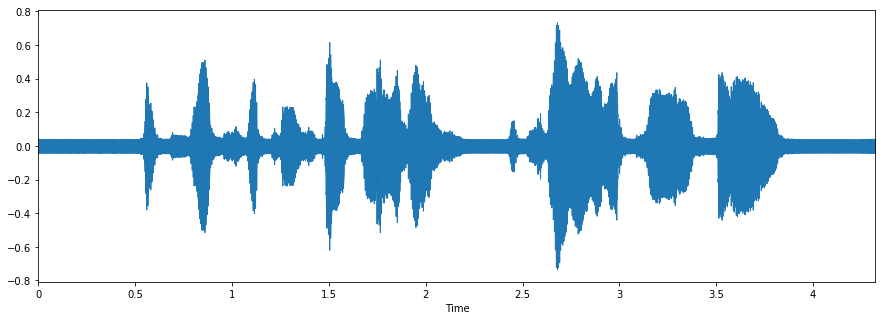

In [ ]:
# use the well known Librosa library for this task.
fname = SAVEE + 'DC_f11.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

So that's a fearful sample. Not alot of background noise and the speech is very clear. So that's good news for us in terms of data quality. The wave plot doesn't really tell much other than there's a variation in the wave, which is good. If it was just a constant oscilating wave form, like those heart-rate-monitors ... then we definitely have a problem.

But we don't which is great. And we can also tell that the audio file is 3 secs. That's good. Its long enough for someone to express an emotion in a sentence, and not too long such that the emotions changes to neutral. How about we play a happy audio file and see how different they are?

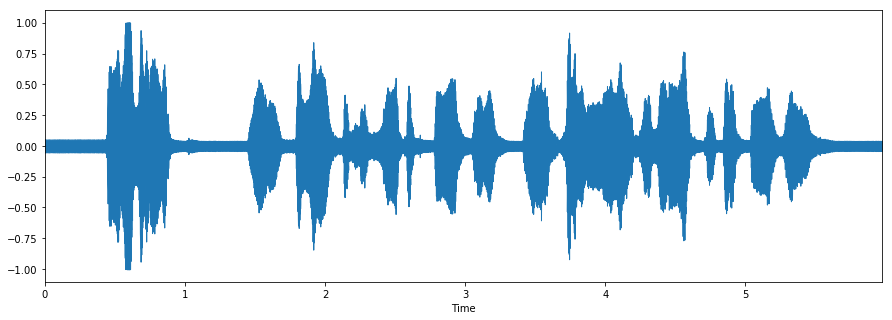

In [ ]:
# Lets play a happy track.
fname = SAVEE + 'DC_h11.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

<a id="savee_con"></a>
### Conclusion
So again, good quality audio. And I can see that the wave form is distinctively different from the fear one. So that's good for our model. I did notice that there's a very short silence period between start and end. We could potentially trim it later to enhance the quality. Also, the sentence uttered is different so its not exactly an apple to apple comparison but it still gives us a good early indication of what we're dealing with.

All in all, I'm happy with this data. We're going to use it for our audio emotion classifier. Now lets look at our next audio dataset...

<a id="ravdess"></a>
## <center>2. RAVDESS dataset</center>

RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename.
_02-01-06-01-02-01-12.mp4_

This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

<a id="ravdess_load"></a>
###  Load the dataset
Because of the way the entire data was packaged for us, and the format of the audio filename, there's a few more parsing steps required for the RAVDESS dataset compared to SAVEE

In [ ]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
male_sad            96
male_happy          96
male_fear           96
female_happy        96
female_angry        96
female_fear         96
female_disgust      96
male_disgust        96
male_angry          96
female_surprise     96
male_surprise       96
female_sad          96
Name: labels, dtype: int64

<a id="ravdess_explore"></a>
### Explore the data
Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Lets start with a fearful track

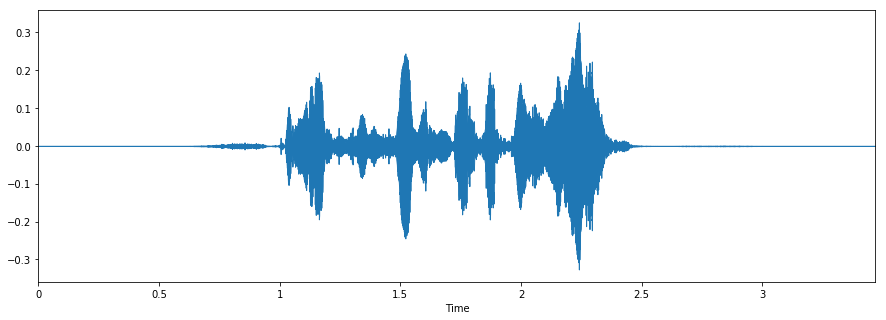

In [ ]:
# Pick a fearful track.
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

Excellent audio quality. And well acted out. I think you can genuinely feel the fear from the speaker. I do notice that there's a lot of silence between the start and end. We'll address it later in later parts. Lets play another random file, maybe a happy one this time.

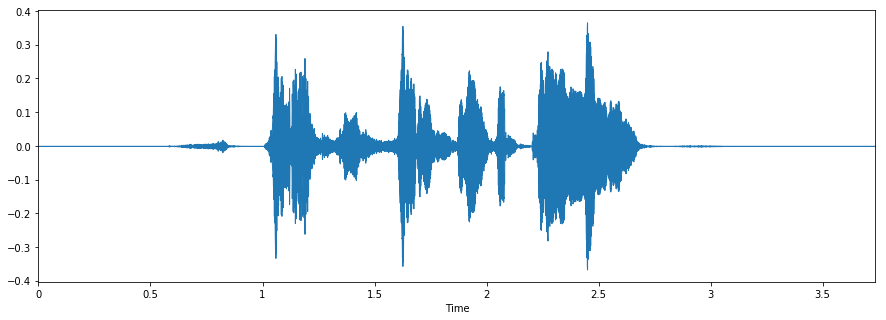

In [ ]:
# Pick a happy track.
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

<a id="ravdess_con"></a>
### Conclusion
...ok, to be fairly honest, I actual felt like that was a fearful tone at the start, up until the end. I had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points. But, could be coincidence, who knows at this stage.

What I do know is that the audio quality is good and we need females in the dataset. If we don't include females, we'll end up with an AI that is bias towards / aagainst one gender, and its unethical. Unless there's a good reason, I'm not taking it out.  

<a id="tess"></a>
##  <center> 3. TESS dataset <center>
Now on to the TESS dataset, its worth nothing that it's only based on 2 speakers, a young female and an older female. This should hopefully balance out the male dominant speakers that we have on SAVEE.

Its got the same 7 key emotions we're interested in. But what is slightly different about this dataset compared to the previous two above, is that the addition of 'pleasant surprise' emotion. I haven't really checked to see for the RADVESS and SAVEE dataset, if the surpises are unpleasant. But I'm going to work with the assumption for now that its a pleasant surprise. If we find out from post modelling, surpise is highly inaccurate, we can come back and modify our assumption here.

<a id="tess_load"></a>
###  Load the dataset
The speakers and the emotions are organised in seperate folders which is very convenient

In [ ]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [ ]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_neutral     400
female_surprise    400
female_happy       400
female_angry       400
female_fear        400
female_disgust     400
female_sad         400
Name: labels, dtype: int64

<a id="tess_explore"></a>
### Explore the data
400 files for each key emotion. Nice. So lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a fearful track

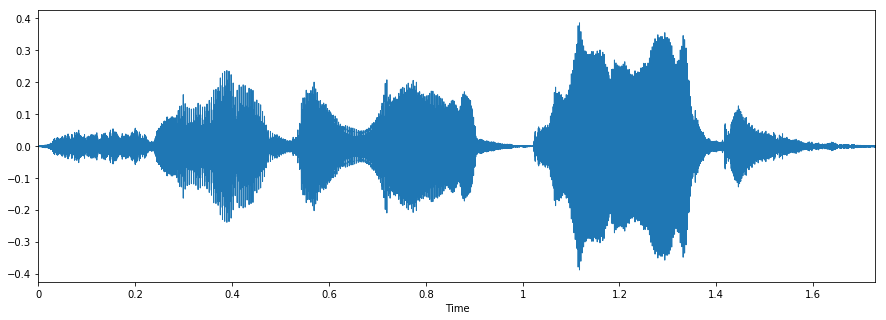

In [ ]:
# lets play a fearful track.
fname = TESS + 'YAF_fear/YAF_dog_fear.wav'

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

She sound almost the same as the female speaker from RAVDESS. Maybe when I have time I will go and investigate but for now,  the most important insight for me is that the expression of the emotions are very similar to RAVDESS and thus is a good indication it will serve as a good training dataset

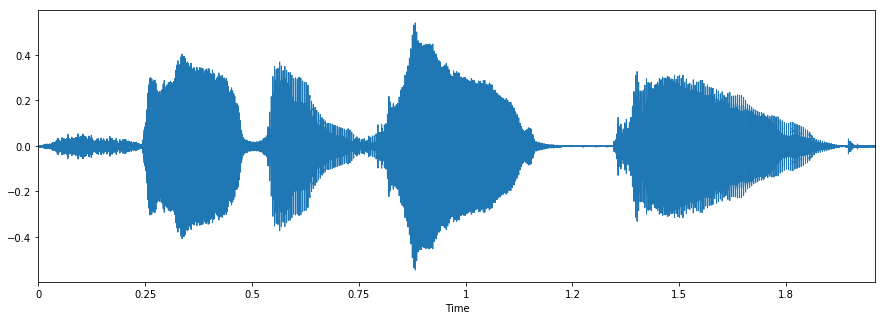

In [ ]:
# lets play a happy track.
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav'

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

<a id="tess_con"></a>
### Conclusion
Thats a beautiful happy voice, I played it a few times I must admit. Notice the amplitute is pretty high too on a few data points? We saw that on the RAVDESS dataset too. Perhaps that could be one of the few distinguishing factors? Because the speakers are the same, and the sentence uttered are the same, its an apples to apples comparison.  

Again, who knows. For now what I do know is that the data quality is amazing and we're using it. The audio duration is about the same too hovering the 2 to 4 seconds mark.

<a id="crema"></a>
##  <center> 4. CREMA-D dataset <center>
Last but not least, CREMA dataset. Not much is known about this dataset and I don't see much usage of this in general in the wild. But its a very large dataset which we need. And it has a good variety of different speakers, apparently taken from movies. And the speakers are of different ethnicities. This is good. Means better generalisation when we do transfer learning. Very important

What we are missing from this dataset is the "surprise" emotion but no biggie, we can use the rest. But we have the rest. What's extra here is that it has different level of intensity of the emotion like RAVDESS. But we won't be using that for now

<a id="crema_load"></a>
###  Load the dataset
The speakers and the emotions like all previous datasets, are tagged in the audio filename itself. However, what we are missing is the Gender, which is kept as a seperate csv file that maps the actors. Instead of reading it and doing some matching, I'm just going to hardcode it here instead. Not the best practice but can do for now.

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [ ]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_happy        671
male_fear         671
male_sad          671
male_disgust      671
female_angry      600
female_fear       600
female_disgust    600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

<a id="crema_explore"></a>
### Explore the data
Ok so that's alot of data. Nice. Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a happy track

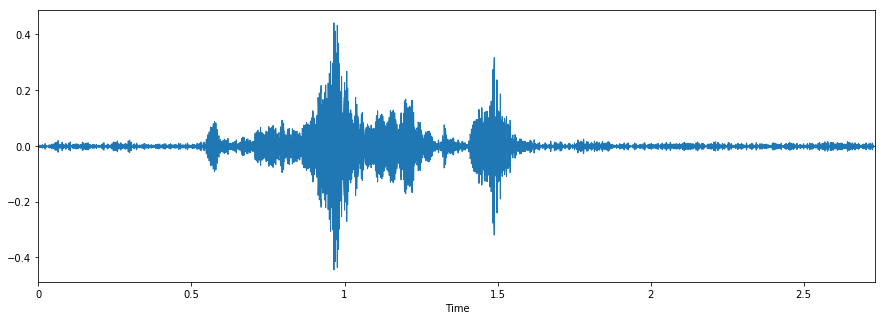

In [ ]:
# use the well known Librosa library for this task.
fname = CREMA + '1012_IEO_HAP_HI.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

So the audio itself is alittle echoey, for the lack of a better word. Its not as clear as what we've seen from the other data sets. And I'm not so sure if it'd consider the emotion happy. Sounds to me more like neutral. But then again, could be due to the audio quality. Lets listen to another one, a fearful one.  

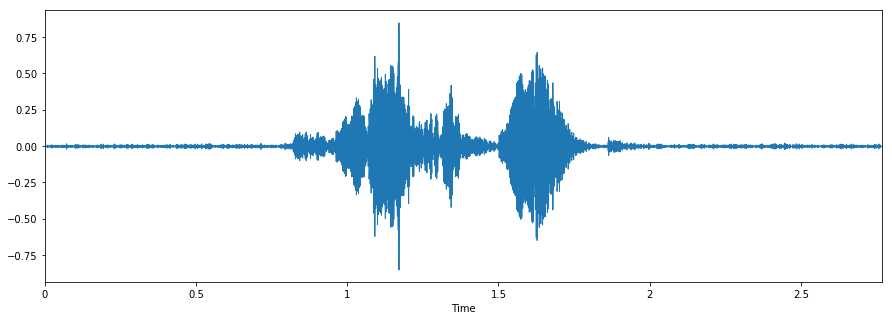

In [ ]:
# A fearful track.
fname = CREMA + '1012_IEO_FEA_HI.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio.
ipd.Audio(fname)

<a id="crema_con"></a>
### Conclusion
The same sentence uttered and quite convincing that its a fearful emotion there. Much clearer than the happy version. Now, I went back to listen a few more random tracks and what I noticed with this CREMA-D dataset is that its is highly varied in its quality. Some are crisp clear and some are really muffled or echoey. Also there's lots of silence as well. All in all, slightly 'dirtier' version of the data. But still good quality data none the less and we'll definitely use it. On the up side, a slightly noisy dataset would serve as a very good data augmentation by introducing noise to the pattern which we don't have so far.

<a id="final"></a>
##  <center> 5. Final thoughts<center>
All 4 dataset are good datasets. Having listen to them and doing some really rough inspections, I feel we can combine all of them. We need to anyway or else we will run into problems with overfitting. One of the issues that I see many other people before me who have made an attempt on an emotion classifier, they tend to stick to just one dataset. And whilst their hold-out set accuracy is high, they don't work well on new unseen dataset.
    
This is because, the classifier is trained on the same dataset and given the similar circumstances that the dataset was obtained or produced, (eg. audio quality, speaker repetition, duration and sentence uttered). To enable it to do well on new datasets, it needs to be given noise, make it work hard to find the real distinguishing characteristics of the emotion.

Before we end it, final steps are to combine all the meta-data together as one. Remember we saved the paths for all the audio files. So this will be handy when we need to read all 4 data sources in different folder structures.

In [ ]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_angry       1096
female_fear        1096
female_disgust     1096
female_happy       1096
female_sad         1096
female_neutral     1056
male_neutral        839
male_happy          827
male_fear           827
male_sad            827
male_angry          827
male_disgust        827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64
